# Algorithm Search

Initial exploration of NSQIP processed data and readmission classification potential using a variety of different ML approaches

In [33]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 6
np.random.seed(seed)

import sklearn
import keras
import tensorflow as tf

print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Keras: {}'.format(keras.__version__))

Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
Keras: 2.3.1


In [34]:
# import the processed dataset
df = pd.read_csv('../data/processed/NSQIP_Clean.csv')

In [35]:
# Describe the dataset
df.describe()

,Unnamed: 0,AGE,WEIGHT,PUFYEAR,OPTIME,TOTHLOS,READMISSION1,SMOKE,HXCOPD,HYPERMED,...,ASA_None assigned,TRAN_From acute care hospital inpatient,TRAN_Not transferred (admitted from home),TRAN_Nursing home - Chronic care - Intermediate care,TRAN_Outside emergency department,TRAN_Transfer from other,DISCHDEST_Home,DISCHDEST_Rehab,"DISCHDEST_Skilled Care, Not Home",DISCHDEST_Unknown
count,2292.00000,1163.000000,2292.000000,2292.000000,2292.00000,2292.000000,1534.000000,2292.000000,2292.000000,2292.000000,...,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000
mean,1145.50000,53.265692,195.593805,2014.034904,160.53185,4.511344,0.095828,0.137871,0.019197,0.452007,...,0.001745,0.020506,0.881763,0.003490,0.015707,0.003054,0.808028,0.020506,0.013962,0.002182
std,661.78773,15.886454,56.636315,2.898939,95.39140,8.998732,0.294451,0.344840,0.137248,0.497800,...,0.041748,0.141755,0.322959,0.058989,0.124366,0.055192,0.393937,0.141755,0.117357,0.046666
min,0.00000,18.000000,-99.000000,2006.000000,0.00000,-99.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,572.75000,41.000000,162.000000,2012.000000,101.00000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1145.50000,55.000000,190.500000,2015.000000,138.00000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1718.25000,65.000000,224.000000,2016.000000,193.00000,5.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2291.00000,88.000000,445.000000,2018.000000,1170.00000,118.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# Handle NaN values in BLEEDIS column by OneHotEncoding for No Bleeding Disorder, Bleeding Disorder, and Unknown

from sklearn.preprocessing import OneHotEncoder

bleed = df['BLEEDIS'].copy()
bleed.replace(np.NaN, 2.0, inplace=True)
encode = OneHotEncoder()

In [37]:
encode.fit(bleed.values.reshape(-1,1))
columns = encode.get_feature_names(['BLEEDIS'])
new = encode.transform(bleed.values.reshape(-1,1)).toarray()
bleedis = pd.DataFrame(new, columns=columns )
bleedis[:5]

,BLEEDIS_0.0,BLEEDIS_1.0,BLEEDIS_2.0
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [38]:
# Replace missing values with median values
for col in df.columns:
    df[col].replace(-99, df[col].median(), inplace=True)
    
df['AGE'].replace(np.NaN, df['AGE'].median(), inplace=True)

# drop BLEEDIS column and add onehotencoded columns
if 'BLEEDIS' in df.columns:
    df.drop(columns=['BLEEDIS'], inplace=True)
df = pd.concat([df, bleedis], axis=1)

# drop rows that don't have readmission defined
df = df[df['READMISSION1'].notna()]

for col in df.columns:
    print('{}: {}'.format(col, df[col].count()))

Unnamed: 0: 1534
AGE: 1534
WEIGHT: 1534
PUFYEAR: 1534
OPTIME: 1534
TOTHLOS: 1534
READMISSION1: 1534
SMOKE: 1534
HXCOPD: 1534
HYPERMED: 1534
DISCANCR: 1534
WNDINF: 1534
STEROID: 1534
WTLOSS: 1534
EMERGNCY: 1534
RETURNOR: 1534
SEX_female: 1534
SEX_male: 1534
RACE_American Indian or Alaska Native: 1534
RACE_Asian: 1534
RACE_Black or African American: 1534
RACE_Native Hawaiian or Pacific Islander: 1534
RACE_Unknown/Not Reported: 1534
RACE_White: 1534
HISPANIC_N: 1534
HISPANIC_U: 1534
HISPANIC_Y: 1534
DIABETES_INSULIN: 1534
DIABETES_NO: 1534
DIABETES_NON-INSULIN: 1534
DYSPNEA_AT REST: 1534
DYSPNEA_MODERATE EXERTION: 1534
DYSPNEA_No: 1534
ASA_1-No Disturb: 1534
ASA_2-Mild Disturb: 1534
ASA_3-Severe Disturb: 1534
ASA_4-Life Threat: 1534
ASA_None assigned: 1534
TRAN_From acute care hospital inpatient: 1534
TRAN_Not transferred (admitted from home): 1534
TRAN_Nursing home - Chronic care - Intermediate care: 1534
TRAN_Outside emergency department: 1534
TRAN_Transfer from other: 1534
DISCHDEST_Ho

In [39]:
# split into scalar and categorical variables
scalar_vars = ['AGE', 'WEIGHT', 'PUFYEAR', 'OPTIME', 'TOTHLOS']
scalar = df[scalar_vars].copy()
categorical = df.drop(columns=scalar_vars).copy()

In [40]:
# Normalize the data using sklearn StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(scalar)

# Transform the training data
X_standardized = scaler.transform(scalar)

scalar_norm = pd.DataFrame(X_standardized)
scalar_norm.describe()

,0,1,2,3,4
count,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03,1.534000e+03
mean,-1.667506e-16,1.516967e-16,6.292055e-14,1.088511e-16,-7.874333e-17
std,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00,1.000326e+00
min,-2.880122e+00,-1.990397e+00,-1.671560e+00,-1.642661e+00,-7.302926e-01
25%,-2.174937e-01,-6.797461e-01,-1.083582e+00,-6.228504e-01,-4.327839e-01
50%,1.052491e-01,-1.222303e-01,9.237467e-02,-2.429210e-01,-2.840296e-01
75%,3.473062e-01,5.135332e-01,6.803529e-01,3.269732e-01,1.347904e-02
max,2.767878e+00,4.797602e+00,1.856309e+00,1.005517e+01,1.682272e+01


In [41]:
data = pd.concat([scalar_norm, categorical.reset_index()], axis=1).drop(columns=['index'])

In [42]:
# split into training and testing datasets
msk = np.random.rand(len(df)) < 0.8
train = data[msk]
test = data[~msk]

# split into input (X) and an output (Y)
Y = train.READMISSION1
X_standardized = train.drop(columns=['READMISSION1', 'Unnamed: 0'])

Y_test = test.READMISSION1
X_test = test.drop(columns=['READMISSION1', 'Unnamed: 0'])

In [43]:
print(X_standardized.shape)
print(Y.shape)

(1206, 48)
(1206,)


In [44]:
# Create a Keras convolutional neural network (CNN), 
# using the parameters found from the exhaustive grid search in 2.0-BTC-CNN_gridsearch.ipynb

# import necessary sklearn and keras packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.layers import Dropout

# Start defining the model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(48, input_dim = 48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(24, input_dim = 48, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [45]:
# import necessary packages for other models
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, make_scorer

# define scoring method
scorer = sklearn.metrics.make_scorer(sklearn.metrics.balanced_accuracy_score)

# Define models to train
names = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "SVM Linear", "SVM RBF", "SVM Sigmoid", "Neural Network"]

classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=seed),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1,  class_weight='balanced', random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GaussianNB(),
    SVC(kernel = 'linear',  class_weight='balanced', probability=True, random_state=seed), 
    SVC(kernel = 'rbf',  class_weight='balanced', probability=True, random_state=seed),
    SVC(kernel = 'sigmoid',  class_weight='balanced', probability=True, random_state=seed),
    KerasClassifier(build_fn = create_model, epochs = 50, batch_size = 5, verbose = 0)]

models = zip(names, classifiers)

# evaluate each model in turn and print results
results = []
names = []
fitted = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_validate(model, X_standardized, Y, scoring=scorer, cv=kfold, n_jobs=1, return_estimator=True)
    results.append(cv_results)
    names.append(name)
    model.fit(X_standardized, Y)
    fitted.append(model)
    msg = "%s: %f (%f)" % (name, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)

Nearest Neighbors: 0.500231 (0.012019)
Decision Tree: 0.551603 (0.060640)
Random Forest: 0.509853 (0.038471)
AdaBoost: 0.542370 (0.036666)
Naive Bayes: 0.497526 (0.010503)
SVM Linear: 0.536258 (0.036179)
SVM RBF: 0.535601 (0.011743)
SVM Sigmoid: 0.493449 (0.060741)
Neural Network: 0.514527 (0.009099)


In [46]:
# print formatted table of K-Fold results for each model
from tabulate import tabulate

scores = []
for algo in results:
    scores.append(list(algo['test_score']))
index = names

print(tabulate(scores, showindex=names))

-----------------  --------  --------  --------  --------  --------
Nearest Neighbors  0.519796  0.484444  0.497717  0.493151  0.506046
Decision Tree      0.541855  0.555972  0.492839  0.663553  0.503793
Random Forest      0.481052  0.4825    0.474782  0.570154  0.540778
AdaBoost           0.578903  0.589306  0.515878  0.493151  0.534614
Naive Bayes        0.492223  0.495417  0.484122  0.500104  0.515766
SVM Linear         0.597709  0.520556  0.490764  0.551162  0.5211
SVM RBF            0.532664  0.531667  0.52034   0.556351  0.536984
SVM Sigmoid        0.580458  0.537083  0.41428   0.493981  0.441441
Neural Network     0.512585  0.522361  0.518161  0.497717  0.521811
-----------------  --------  --------  --------  --------  --------


In [47]:
import matplotlib.pyplot as plt

def generate_roc_curves(models, names, X_test, Y_test):
    
    plt.figure(figsize=(10,10))
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(Y_test))]
    
    for i,model in enumerate(models):
        
        # predict probabilities
        lr_probs = model.predict_proba(X_test)
        
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        
        # calculate scores and curve
        lr_auc = sklearn.metrics.roc_auc_score(Y_test, lr_probs)
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(Y_test, lr_probs)
        
        # plot the roc curve for the model
        plt.plot(lr_fpr, lr_tpr, marker='', label='{} (AUC = {})'.format(names[i], round(lr_auc,3)))
    
    # plot the roc curve for the no skill model
    ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(Y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc = 'lower right')
    # show the plot
    plt.show()
    
    return None

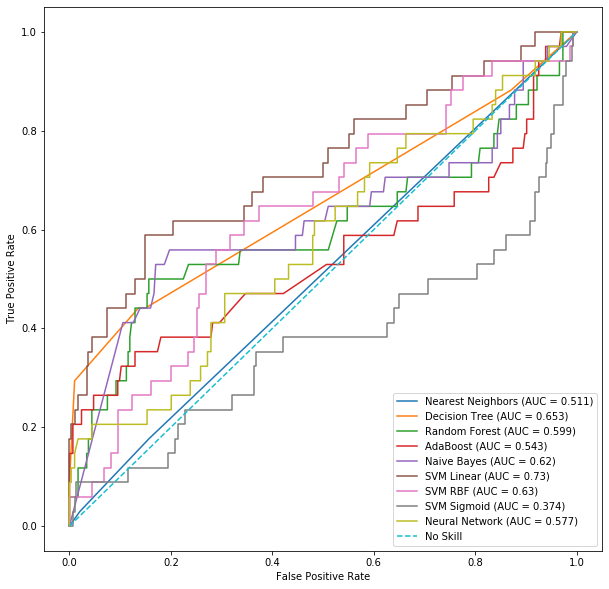

In [48]:
generate_roc_curves(fitted, names, X_test, Y_test)

In [49]:
def scores(Y_test, y_pred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(Y_test, y_pred).ravel()
    print('{}, {}, {}, {}\n'.format(tn, fp, fn, tp))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    PPV = tp / (tp + fp)
    NPV = tn / (tn + fn)

    print('Sensitivity: {}'.format(sensitivity))
    print('Specificity: {}'.format(specificity))
    print('PPV: {}'.format(PPV))
    print('NPV: {}'.format(NPV))

    return None

curves = []

for model in fitted:
    y_pred = model.predict(X_test)
    print(model)
    print(classification_report(Y_test, y_pred))
    scores(Y_test, y_pred)
    curves.append(sklearn.metrics.roc_curve(Y_test, y_pred))
    print('\n')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       294
         1.0       0.14      0.03      0.05        34

    accuracy                           0.88       328
   macro avg       0.52      0.50      0.49       328
weighted avg       0.82      0.88      0.84       328

288, 6, 33, 1

Sensitivity: 0.029411764705882353
Specificity: 0.9795918367346939
PPV: 0.14285714285714285
NPV: 0.897196261682243


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presor